# Travelling Salesman Problem by Brute Force and Simulated Annealing Algorithm

### Imports

In [1]:
import sys
import time
import copy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import cities as tdc
from anneal import SimAnneal
import random

### HELPER FUNCTIONS

In [2]:
def getEnergy(cities, indices):
    """
    Transform indices to coordinates, then find route length
    """

    all_indices = [ i for i in indices]
    all_indices.append(0)
    route = [ cities.coords[index] for index in all_indices]
    return tdc.routeLength(route)

def getNeighbor(current_soln):
    """
    Generate a neighboring route to the current solution by randomly selecting
    two cities and swapping their positions.
    """
    # Make deep copy of current solution to fill
    neighbor_soln = copy.deepcopy(current_soln)

    # Get indices of cities to swap
    indexA, indexB = np.random.choice(range(len(current_soln)), size=2, replace=False)

    # Swap values
    newA, newB = neighbor_soln[indexB], neighbor_soln[indexA]
    neighbor_soln[indexA], neighbor_soln[indexB] = newA, newB

    return neighbor_soln

def acceptNeighbor(currentE, neighborE, temp):
    """
    Our acceptance PDF is P = Bernoulli(exp((currentE - neighborE)/temp))
    if neighbor solution is better than current solution (currentE < neighborE) then
    accept with prob = 1, otherwise switch to neighbor solution with prob P
    """
    if neighborE < currentE:
        return 1
    else:
        return np.random.binomial(1, np.exp((currentE - neighborE)/temp))

def align_yaxis(ax1, v1, ax2, v2):
    """
    adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1
    """
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

### Simulated Annealing  Algorithm

In [3]:
def runAnnealing(cities, start_temp=1e4, end_temp=1, cooling_rate=0.003):
    """
    Take a grid_2d_cities class instance and find its shortest route via
    simulated annealing. We start by setting initial temperature and taking an
    initial solution, then loop until stopping condition (temp <= end_temp) is
    met as follows:
      1) Select a neighbor solution by making a small change to current solution.
      2) Draw from acceptance PDF to determine whether to move to neighbor.
      3) Decrease temperature and continue looping.
    Neighbor solutions are found by taking two random cities on the current
    solution and swapping them. We use total solution length as our "energy" E
    here. Our acceptance PDF is
       P = exp( (E_current - E_neighbor)/temp )
    If neighbor solution is better than current solution (E_neigh < E_curr),
    accept neighbor with prob = 1. Otherwise switch to neighbor solution with
    probability P.
    """

    # fixing city 0 as starting and ending point. Consider only cities from [1, ncities-1]
    current_soln = [ i for i in range(1, cities.ncities)]

    # Find the length (aka energy) of this first solution
    currentE = getEnergy(cities, current_soln)
    print("Starting distance: {:.3f}".format(currentE))

    # Save the best solution found at any point
    bestE = currentE
    best_soln = current_soln

    # Creating list of energy and temperature for annealing loop
    energy_list, temp_list = [], []
    temp = start_temp

    # Begin Annealing
    while temp > end_temp:
        # Generate neighbor solution and find its energy
        neighbor_soln = getNeighbor(current_soln)
        neighborE = getEnergy(cities, neighbor_soln)

        # Accept the neighbor solution ?
        if acceptNeighbor(currentE, neighborE, temp):
            current_soln = neighbor_soln
            currentE = neighborE

        # Store results
        temp_list.append(temp)
        energy_list.append(currentE)

        # If current solution is best yet, save it
        if currentE < bestE:
            best_soln = current_soln
            bestE = currentE

        # Lower the temperature
        temp *= 1 - cooling_rate

    return best_soln, energy_list, temp_list


------------------------------Brute force------------------------------
Brute force solution has length: 40.270
Brute force total time: 20.03 sec


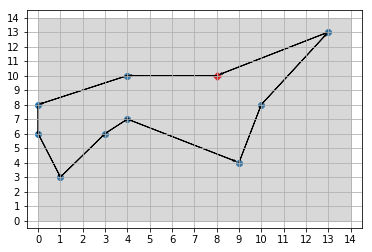

------------------------------Simulated Annealing------------------------------
Starting distance: 69.671
Lowest Energy: 40.270 Number of iterations: 3066
Simulated Annealing Total time: 0.36 sec


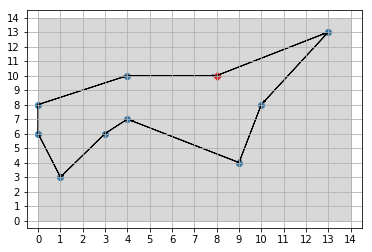

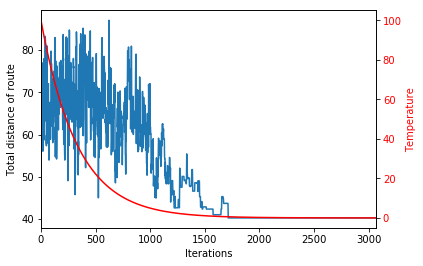

------------------------------Simulated Annealing for 5 cities------------------------------
Starting distance: 11.256
Simulated Annealing Total time: 0.23 sec
------------------------------Simulated Annealing for 55 cities------------------------------
Starting distance: 1430.849
Simulated Annealing Total time: 1.23 sec
------------------------------Simulated Annealing for 105 cities------------------------------
Starting distance: 5978.867
Simulated Annealing Total time: 2.21 sec
------------------------------Simulated Annealing for 155 cities------------------------------
Starting distance: 12347.604
Simulated Annealing Total time: 3.29 sec
------------------------------Simulated Annealing for 205 cities------------------------------
Starting distance: 21215.593
Simulated Annealing Total time: 4.15 sec
------------------------------Simulated Annealing for 255 cities------------------------------
Starting distance: 33869.854
Simulated Annealing Total time: 4.99 sec
------------------

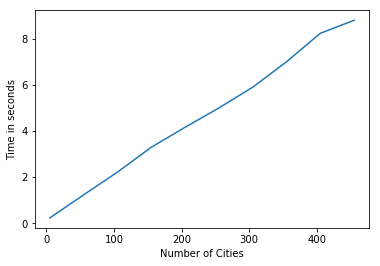

In [4]:
def main(cities):
    """
    This functions runs a brute force solution and Simulated Annealing solution, compares
    the performance time
    Also it visualizes the plot between cost of distances and temperature together with 
    number of iterations
    """
    # Brute force solution
    print("-"*30 + "Brute force" + "-"*30)
    startBF = time.time()
    cities.bruteShortest()
    timeBF = time.time() - startBF
    print("Brute force total time: {:.2f} sec".format(timeBF))
    cities.drawCities()

    # Simulated Annealing solution
    print("-"*30 + "Simulated Annealing" + "-"*30)
    startSA = time.time()
    simAnn_soln, energy_list, temp_list = runAnnealing(cities, 100, 0.01)
    timeSA = time.time() - startSA

    print("Lowest Energy: {:.3f} Number of iterations: {}".format(min(energy_list), len(energy_list)))
    print("Simulated Annealing Total time: {:.2f} sec".format(timeSA))
    cities.drawCities([ cities.coords[i] for i in [0]+simAnn_soln])

    # Plot energy and temperature together
    fig, ax1 = plt.subplots()
    ax1.plot(energy_list,)
    ax1.set_ylabel('Total distance of route')
    ax1.set_xlabel('Iterations')

    ax2 = ax1.twinx()
    ax2.plot(temp_list, color='red')
    ax2.set_ylabel('Temperature',color='red')
    for tk in ax2.get_yticklabels():
        tk.set_color('red')

    align_yaxis(ax1, min(energy_list), ax2, min(temp_list))
    ax2.set_xlim([0, len(energy_list)])
    plt.show();



if __name__ == "__main__":
    np.random.seed(3)
    cities = tdc.grid_2d_cities(10, 15, 15)
    main(cities)
    
    # Simulated Annealing solution for different cities
    t = []
    city = np.arange(5,500, 50)
    for i in city:
        mycity = tdc.grid_2d_cities(i)
        print("-"*30 + "Simulated Annealing for " + str(i) + " cities" + "-"*30)
        startSA = time.time()
        simAnn_soln, energy_list, temp_list = runAnnealing(mycity, 100, 0.01)
        timeSA = time.time() - startSA
        t.append(timeSA)
        print("Simulated Annealing Total time: {:.2f} sec".format(timeSA))
    
    # plot for time over number of cities
    plt.plot(city, t)
    plt.xlabel("Number of Cities")
    plt.ylabel("Time in seconds")
    plt.show()


## Test with Python implementation of Simulated Annealing 

------------ SIM ANNEALING TEST -------------
Best fitness obtained:  41.0295
Improvement over greedy heuristic:  0.1728
Time: 0.03 sec


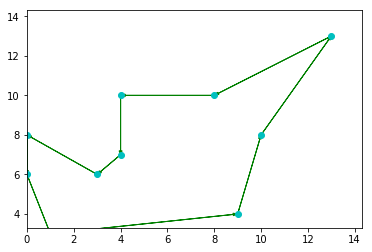

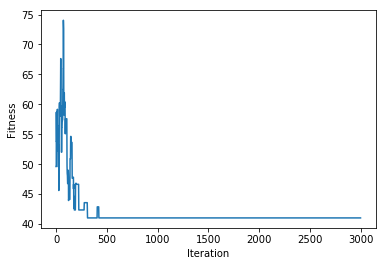

In [5]:
print("------------ SIM ANNEALING TEST -------------")
np.random.seed()
sa1 = SimAnneal(cities.coords, stopping_iter = 3000)
st = time.time()
sa1.Anneal()
end = time.time() - st
print("Time: {:.2f} sec".format(end))
sa1.visualizeRotes()
sa1.plotLearning()